In [1]:
from pysymbolic.algorithms.symbolic_metamodeling import *
import numpy as np
import pandas as pd

In [2]:
path = './'
file_name = 'COVID_V7.xlsx'
full_file_path = path + file_name

In [3]:
#from preprocess import clean_data
all_data = pd.read_excel(full_file_path, sheet_name='Sheet1')
print('all_data len:', len(all_data.index))
print('all_data columns len:', len(all_data.columns))

all_data len: 538
all_data columns len: 26


In [4]:
col_type_dict = {'Age':True, 'SEX':True, 'BMI':False, 'Prior_Co1':True, 'Prior_Co2':True, 'Prior_Co3':True, 'Prior_Co6':True,
       'Prior_Co24':True, 'Alco':True, 'Smoke':True, 'SYMP1':True, 'SYMP2':True, 'SYMP3':True, 'SYMP5':True,
       'SYMP6':True, 'SYMP11':True, 'SYMP12':True, 'SYMP20':True, 'SPO':False, 'WBC':False, 'Hgb':False,
       'Hct':False, 'MCV':False, 'Plate':False, 'Neutro':False, 'Lymp':False, 'DIMER':True, 'Glucose':True, 'BUN':True,
       'CR':False, 'GFR_BIN':True, 'AKI':True, 'NA_I':True, 'K_I':False, 'BIC':False, 'ALB_I':False, 'TBILI':False, 'ALK_I':True,
       'ALT_I':True, 'AST_I':True, 'Trop_BIN':True, 'CRP':False, 'CXR2':True, 'CXR6':True, 'CXR7':True, 'EKG':True,
       'SEVER':True, 'RACE_E':True, 'LENG':True, 'LENG_ICU':True, 'Mech':True, 'DIED':True, 'ICU':True}

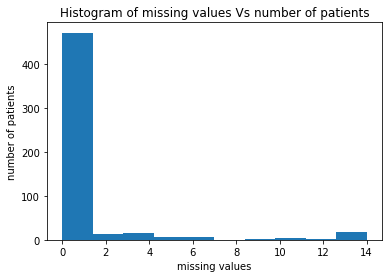

In [5]:
import matplotlib.pyplot as plt
tgt_col='SEVER'
died_col = 'DIED'
icu_col = 'ICU'
sever_col = 'SEVER'
mech_col = 'Mech'
leng_col = 'LENG'
leng_icu_col = 'LENG_ICU'
#spol_col = 'SPO'
#result_cols = [died_col, icu_col, sever_col, mech_col, leng_col, leng_icu_col, spol_col]
result_cols = [died_col, icu_col, sever_col, mech_col, leng_col, leng_icu_col]
result_cols.remove(tgt_col)
features = np.setdiff1d(all_data.columns,  result_cols).tolist()
all_data = all_data[features]



plt.xlabel('missing values')
plt.ylabel('number of patients')
plt.title('Histogram of missing values Vs number of patients' )
plt.hist(all_data.isnull().sum(axis=1).tolist())
plt.savefig('./hist.png')

In [6]:
thresh3_val = 0
df = all_data[all_data.isnull().sum(axis=1) > thresh3_val ].index
print('len df', len(df))
all_data.drop(all_data.index[df], inplace=True)
all_data.reset_index(drop=True, inplace=True)

len df 146


In [8]:
normalization_not_required = {'Age':False, 'SEX':True, 'BMI':False, 'Prior_Co1':True, 'Prior_Co2':True, 'Prior_Co3':True, 'Prior_Co6':True,
       'Prior_Co24':True, 'Alco':True, 'Smoke':True, 'SYMP1':True, 'SYMP2':True, 'SYMP3':True, 'SYMP5':True,
       'SYMP6':True, 'SYMP11':True, 'SYMP12':True, 'SYMP20':True, 'SPO':False, 'WBC':False, 'Hgb':False,
       'Hct':False, 'MCV':False, 'Plate':False, 'Neutro':False, 'Lymp':False, 'DIMER':False, 'Glucose':False, 'BUN':False,
       'CR':False, 'GFR_BIN':True, 'AKI':True, 'NA_I':False, 'K_I':False, 'BIC':False, 'ALB_I':False, 'TBILI':False, 'ALK_I':False,
       'ALT_I':False, 'AST_I':False, 'Trop_BIN':True, 'CRP':False, 'CXR2':True, 'CXR6':True, 'CXR7':True, 'EKG':False,
       'SEVER':True, 'RACE_E':False, 'LENG':True, 'LENG_ICU':True, 'Mech':True, 'DIED':True, 'ICU':True}

In [9]:
from sklearn.preprocessing import MinMaxScaler
# normalize the features
scale_feas = []
for col in all_data.columns:
    if normalization_not_required[col] is False:
        scale_feas.append(col)
#print(scale_feas)
all_data_temp = all_data.copy()
features = all_data_temp[scale_feas]
#scaler = StandardScaler().fit(features.values)
scaler = MinMaxScaler().fit(features.values)
features = scaler.transform(features.values)
all_data[scale_feas] = features
#print(all_data)

In [10]:
len(all_data.index)
#all_data

392

In [11]:
len(all_data.columns)

21

In [12]:
y = all_data[tgt_col].copy()
all_data.drop(columns=[tgt_col], inplace=True)
X = all_data.copy()

In [13]:
from sklearn.model_selection import train_test_split
seed = 19
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

In [14]:
len(X_train)

274

In [16]:
import lightgbm as lgb
model = lgb.LGBMClassifier(num_leaves=63,
                        learning_rate=0.0005,
                        min_split_gain=0.3,
                        colsample_bytree=0.7,
                        reg_alpha=1.2,
                        reg_lambda=1.1,
                        subsample=0.7,
                        subsample_freq=20,
                        n_estimators=100,is_unbalance=True)

model.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
               importance_type='split', is_unbalance=True, learning_rate=0.0005,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.3, n_estimators=100, n_jobs=-1, num_leaves=63,
               objective=None, random_state=None, reg_alpha=1.2, reg_lambda=1.1,
               silent=True, subsample=0.7, subsample_for_bin=200000,
               subsample_freq=20)

Let us examine the AUC-ROC performance of the fitted lightGBM model on the test data

In [17]:
#roc_auc_score(y_test, model.predict(X_test))
roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

0.8333333333333333

Now let us create a symbolic metamodel instance. This takes the fitted model **model** and the training features **X_train** as follows

In [18]:
metamodel = symbolic_metamodel(model, X_train)

#metamodel.fit(num_iter=10, batch_size=X_train.shape[0], learning_rate=.01)
metamodel.fit(num_iter=100, batch_size=X_train.shape[0], learning_rate=.001)

---- Tuning the basis functions ----



----  Optimizing the metamodel  ----


Now let us see how this metamodel performs using the **evaluate** method...

In [19]:
Y_metamodel = metamodel.evaluate(X_train)

roc_auc_score(y_train, Y_metamodel)

0.7705389848246991

In [20]:
Y_metamodel = metamodel.evaluate(X_test)

roc_auc_score(y_test, Y_metamodel)

0.7628726287262872

In [23]:
X_test.shape

(118, 20)

In [24]:
Y_metamodel.shape

(118,)

In [25]:
Y_metamodel[1]

0.298399103740101

Now we show how to extract the exact and approximate equation $g(x)$ from the metamodel class...

In [26]:
metamodel.exact_expression

1/(exp(7.5686689115458e-26*re(X0**2.2036880601277*hyper((1.0, 1.0), (2.28070513594069,), 1.64503104850843e-6*X0*exp_polar(I*pi))) + 0.000731567577171361*re(X1**2.4952094159523*hyper((1.0, 1.0), (2.60676515938681,), 0.329083501627018*X1*exp_polar(I*pi))) + 1.32092717891315e-21*re(X10**2.20903626693271*hyper((1.0, 1.0), (2.28890189517976,), 1.62119231007414e-5*X10*exp_polar(I*pi))) + 0.000588722023194667*re(X11**2.45784638458418*hyper((1.0, 1.0), (2.56884136880499,), 0.305392623081555*X11*exp_polar(I*pi))) + 2.23259381126961e-18*re(X12**2.34816551213419*hyper((1.0, 1.0), (2.46246090659257,), 0.00021234353666459*X12*exp_polar(I*pi))) + 8.58301556120649e-19*re(X13**2.35070089166298*hyper((1.0, 1.0), (2.46609121762498,), 0.000203563782131373*X13*exp_polar(I*pi))) + 1.03593988343109e-9*re(X14**2.47229325609132*hyper((1.0, 1.0), (2.59698962844417,), 0.0213834906821715*X14*exp_polar(I*pi))) + 4.42963819715185e-21*re(X16**2.27855976008783*hyper((1.0, 1.0), (2.37687594020183,), 3.25764906502204e

Because this equation involves Hypergeometric functions, we might prefer to work with the polynomial approximation...

In [27]:
metamodel.approx_expression

1/(2.34716245989743*exp(0.0209918941312954*X0**3*X1**3 - 0.000646317274258766*X0**3*X10**3 - 0.00591512924466727*X0**3*X11**3 + 0.00607305991010177*X0**3*X12**3 + 0.00317067920081538*X0**3*X13**3 + 0.0106472347712655*X0**3*X14**3 + 0.000606736847386888*X0**3*X15**3 + 0.00186011254201104*X0**3*X16**3 + 0.00131197097240821*X0**3*X17**3 - 0.0137562349007312*X0**3*X18**3 - 0.0040636163517389*X0**3*X19**3 + 0.0201302770871487*X0**3*X2**3 - 0.0291133344362144*X0**3*X3**3 + 0.00123913075448619*X0**3*X4**3 - 0.0247496231038554*X0**3*X5**3 - 0.0022469930822971*X0**3*X6**3 - 0.000553103077773011*X0**3*X7**3 - 0.0122288701100427*X0**3*X8**3 - 0.0121317041671598*X0**3*X9**3 + 1.18361161106775e-26*X0**3 - 0.00935730885232601*X0**2*X1**2 + 0.000292304637941242*X0**2*X10**2 + 0.00264838902882534*X0**2*X11**2 - 0.00269647559742486*X0**2*X12**2 - 0.00138893079371189*X0**2*X13**2 - 0.00473942656225323*X0**2*X14**2 - 0.000271993635507775*X0**2*X15**2 - 0.000836201104042875*X0**2*X16**2 - 0.00059038849746

In [28]:
from sympy.printing.latex import latex
latex(metamodel.approx_expression)

'\\frac{1}{2.34716245989743 e^{0.0209918941312954 X_{0}^{3} X_{1}^{3} - 0.000646317274258766 X_{0}^{3} X_{10}^{3} - 0.00591512924466727 X_{0}^{3} X_{11}^{3} + 0.00607305991010177 X_{0}^{3} X_{12}^{3} + 0.00317067920081538 X_{0}^{3} X_{13}^{3} + 0.0106472347712655 X_{0}^{3} X_{14}^{3} + 0.000606736847386888 X_{0}^{3} X_{15}^{3} + 0.00186011254201104 X_{0}^{3} X_{16}^{3} + 0.00131197097240821 X_{0}^{3} X_{17}^{3} - 0.0137562349007312 X_{0}^{3} X_{18}^{3} - 0.0040636163517389 X_{0}^{3} X_{19}^{3} + 0.0201302770871487 X_{0}^{3} X_{2}^{3} - 0.0291133344362144 X_{0}^{3} X_{3}^{3} + 0.00123913075448619 X_{0}^{3} X_{4}^{3} - 0.0247496231038554 X_{0}^{3} X_{5}^{3} - 0.0022469930822971 X_{0}^{3} X_{6}^{3} - 0.000553103077773011 X_{0}^{3} X_{7}^{3} - 0.0122288701100427 X_{0}^{3} X_{8}^{3} - 0.0121317041671598 X_{0}^{3} X_{9}^{3} + 1.18361161106775 \\cdot 10^{-26} X_{0}^{3} - 0.00935730885232601 X_{0}^{2} X_{1}^{2} + 0.000292304637941242 X_{0}^{2} X_{10}^{2} + 0.00264838902882534 X_{0}^{2} X_{11}^

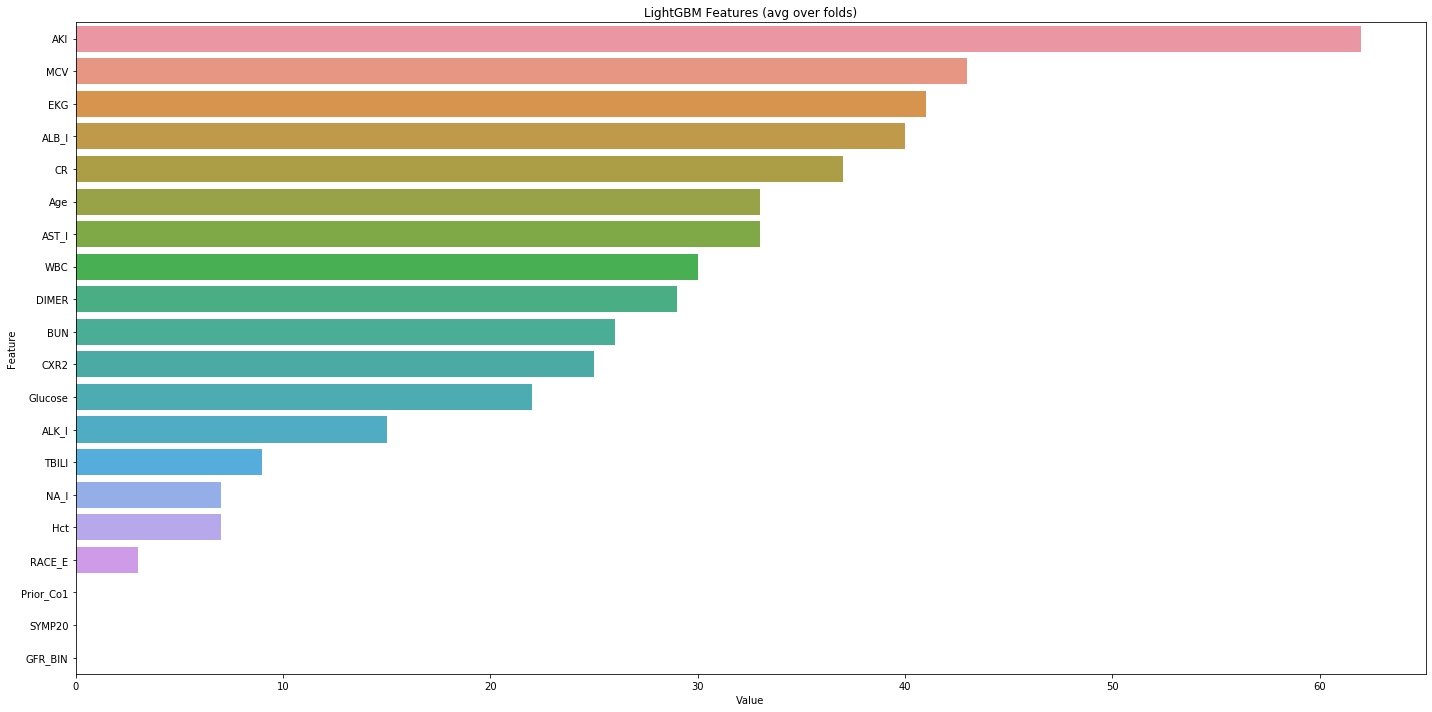

<Figure size 432x288 with 0 Axes>

In [29]:
# code reference from https://www.kaggle.com/ashishpatel26/feature-importance-of-lightgbm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')